In [12]:
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks

In [13]:
with open("S10_af_time_series.pkl", "rb") as f:
    data = pickle.load(f)

afs = data["data"]
metas = pd.read_excel("S11_af_meta.xlsx")
weld_end = pd.read_excel("S12_1_af_weld_end.xlsx")

In [14]:
metas

,sample_no,DynoWare,Path,Filename,Config ID,Setup ID,Manipulated,Filename 1,Filename 2,Date,...,Delay time [s],Cycle time [s],Cycles,Samples per channel,Cycle interval,Cycle No,filename,R,D,W
0,1,Version 3.2.2.0,D:\Parn (paper ML Weld)\Post welding\,Sample 1.dwd,Sample 1.cfg,0,0,NaN,NaN,"Wednesday, January 01, 2025",...,0,0,1,18001,0,1,Sample 1.csv,1400,10,60
1,2,Version 3.2.2.0,D:\Parn (paper ML Weld)\Post welding\,Sample 2.dwd,Sample 2.cfg,0,0,NaN,NaN,"Wednesday, January 01, 2025",...,0,0,1,18001,0,1,Sample 2.csv,1400,15,60
2,3,Version 3.2.2.0,D:\Parn (paper ML Weld)\Post welding\,Sample 3.dwd,Sample 3.cfg,0,0,NaN,NaN,"Wednesday, January 01, 2025",...,0,0,1,18001,0,1,Sample 3.csv,1400,20,60
3,4,Version 3.2.2.0,D:\Parn (paper ML Weld)\Post welding\,Sample 4.dwd,Sample 4.cfg,0,0,NaN,NaN,"Wednesday, January 01, 2025",...,0,0,1,18001,0,1,Sample 4.csv,1400,10,70
4,5,Version 3.2.2.0,D:\Parn (paper ML Weld)\Post welding\,Sample 5.dwd,Sample 5.cfg,0,0,NaN,NaN,"Wednesday, January 01, 2025",...,0,0,1,18001,0,1,Sample 5.csv,1400,15,70
5,6,Version 3.2.2.0,D:\Parn (paper ML Weld)\Post welding\,Sample 6.dwd,Sample 6.cfg,0,0,NaN,NaN,"Wednesday, January 01, 2025",...,0,0,1,18001,0,1,Sample 6.csv,1400,20,70
6,7,Version 3.2.2.0,D:\Parn (paper ML Weld)\Post welding\,Sample 7.dwd,Sample 7.cfg,0,0,NaN,NaN,"Wednesday, January 01, 2025",...,0,0,1,18001,0,1,Sample 7.csv,1400,10,80
7,8,Version 3.2.2.0,D:\Parn (paper ML Weld)\Post welding\,Sample 8.dwd,Sample 8.cfg,0,0,NaN,NaN,"Wednesday, January 01, 2025",...,0,0,1,18001,0,1,Sample 8.csv,1400,15,80
8,9,Version 3.2.2.0,D:\Parn (paper ML Weld)\Post welding\,Sample 9.dwd,Sample 9.cfg,0,0,NaN,NaN,"Wednesday, January 01, 2025",...,0,0,1,18001,0,1,Sample 9.csv,1400,20,80
9,10,Version 3.2.2.0,D:\Parn (paper ML Weld)\Post welding\,Sample 10.dwd,Sample 10.cfg,0,0,NaN,NaN,"Wednesday, January 01, 2025",...,0,0,1,18001,0,1,Sample 10.csv,1500,10,60


In [15]:
weld_end

,sample_no,drop_idx_chosen,drop_threshold,weld_time_end_idx,weld_time_end
0,1,-1,-3,16856,168.56
1,2,-1,-3,17262,172.62
2,3,-1,-3,17824,178.24
3,4,-1,-3,14807,148.07
4,5,-1,-3,15388,153.88
5,6,-1,-3,15509,155.09
6,7,-1,-3,13199,131.99
7,8,-1,-3,13840,138.40
8,9,-1,-3,14537,145.37
9,10,-1,-3,16532,165.32


In [16]:
afs

,Time,Mz,Fz,Fy,Fx,sample_no
0,0.00,0.297328,0.044294,0.006714,0.004425,1
1,0.01,0.061471,0.029864,0.000741,-0.000011,1
2,0.02,0.296021,0.044425,0.006616,0.004381,1
3,0.03,0.061907,0.029253,0.000708,0.000011,1
4,0.04,0.301252,0.043509,0.006801,0.004469,1
...,...,...,...,...,...,...
972049,179.96,12.385800,0.244707,-0.010027,-0.015117,9
972050,179.97,12.677900,0.262844,-0.002616,-0.009668,9
972051,179.98,12.389700,0.245361,-0.010005,-0.015063,9
972052,179.99,12.678700,0.263192,-0.002638,-0.009635,9


Sample No: 1, D: 10s, Sampling Rate: 100Hz, W: 60 mm/min
Weld Time: 130.0s
time_start: 28.560000000000002s, time_end: 38.56s
time_start_idx: 2856, time_end_idx: 3856
Dwell Time (actual): 10.0s


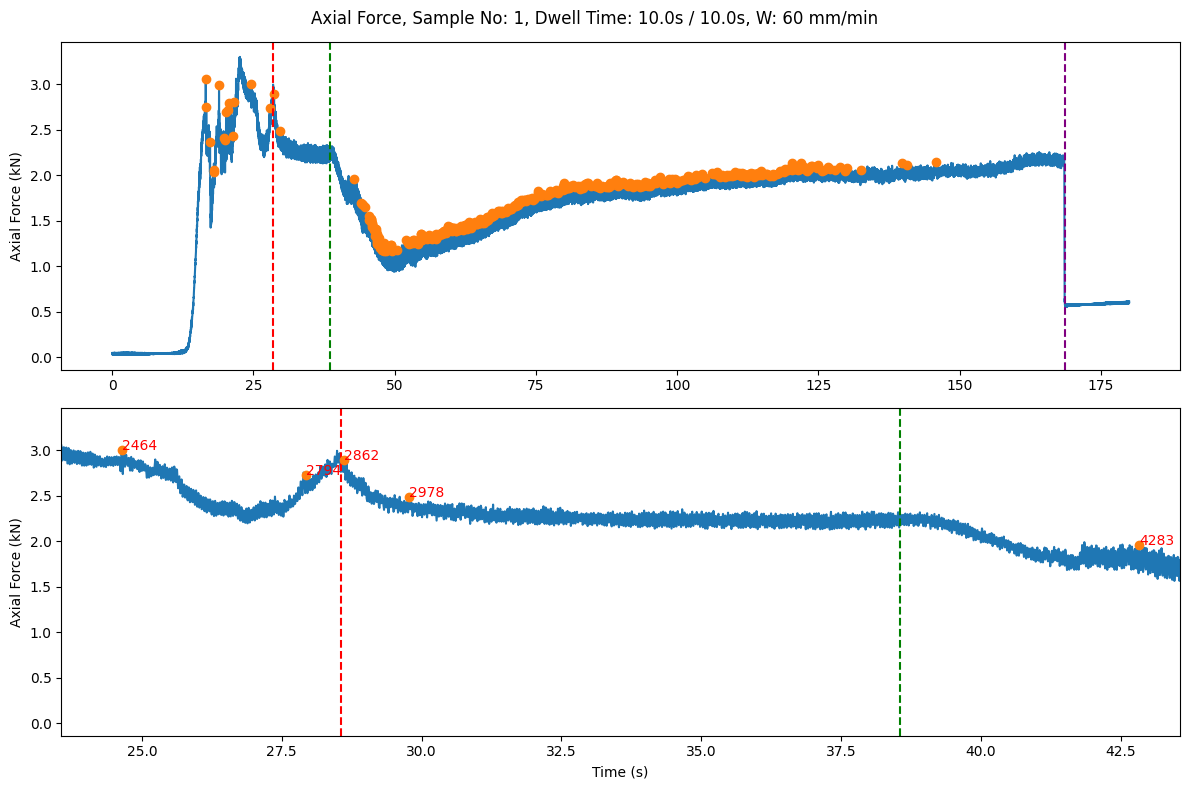

In [55]:
# Experimentation with a single sample
# Height is the required height of peaks: (min, max)
# Threshold is the required vertical distance to its neighboring samples0

sample_no = 1
peak_condition = dict(height=(1, None), threshold=0.1)
idx_start_chosen = None
idx_end_chosen = None

# Extract relevant data
dwell_time = metas.loc[metas["sample_no"] == sample_no, "D"].values[0]
sampling_rate = metas.loc[metas["sample_no"] == sample_no, "Sampling rate [Hz]"].values[
    0
]
_weld_speed = metas.loc[metas["sample_no"] == sample_no, "W"].values[0] # mm/min
weld_speed = _weld_speed / 60  # Convert to mm/s
af = afs.loc[afs["sample_no"] == sample_no].reset_index(drop=True)
af.set_index("Time", inplace=True)
weld_time_end = weld_end.loc[weld_end["sample_no"] == sample_no, "weld_time_end"].values[0]
weld_time_end_idx = weld_end.loc[weld_end["sample_no"] == sample_no, "weld_time_end_idx"].values[0]

# Weld time is calculated from the speed and length of sample which is 130 mm
weld_time = 130 / weld_speed

# Estimate dwell time checkpoints
dwell_time_end_approx = weld_time_end - weld_time

# Find peaks in axial force data
peak_idxes, props = find_peaks(af["Fz"], **peak_condition)

# Choose dwell time end based on peak indexes
if idx_end_chosen is None: # Auto select based on dwell time
    dwell_time_end_idx = af.index.get_indexer([dwell_time_end_approx], method="nearest")[0]
else:
    if idx_end_chosen < 0:
        raise ValueError("idx_end_chosen must be non-negative integer.")
    else:
        dwell_time_end_idx = idx_end_chosen
dwell_time_end = af.index[dwell_time_end_idx]

# Choose dwell time start 
if idx_start_chosen is None: # Auto select based on dwell time
    dwell_time_start = dwell_time_end - dwell_time
    dwell_time_start_idx = af.index.get_indexer([dwell_time_start], method="nearest")[0]       
else: # Manual select
    if idx_start_chosen < 0:
        raise ValueError("idx_start_chosen must be non-negative integer.")
    elif idx_start_chosen <= 10: # Select from peak indexes
        dwell_time_start_idx = peak_idxes[idx_start_chosen]
        dwell_time_start = af.index[dwell_time_start_idx]
    else: # Directly specify index
        dwell_time_start_idx = idx_start_chosen
        dwell_time_start = af.index[dwell_time_start_idx]

# Actual dwell time
dwell_time_actual = dwell_time_end - dwell_time_start

# Summary printout
print(
    f"Sample No: {sample_no}, D: {dwell_time}s, Sampling Rate: {sampling_rate}Hz, W: {_weld_speed} mm/min"
)
print(f"Weld Time: {weld_time}s")
print(f"time_start: {dwell_time_start}s, time_end: {dwell_time_end}s")
print(f"time_start_idx: {dwell_time_start_idx}, time_end_idx: {dwell_time_end_idx}")
print(f"Dwell Time (actual): {dwell_time_actual}s")

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(af.index, af["Fz"], label="Axial Force (Fz)")
axes[0].plot(af.index[peak_idxes], af["Fz"].iloc[peak_idxes], "o", label="Peaks")
axes[0].axvline(x= dwell_time_start, color="red", linestyle="--", label="Dwell Start")
axes[0].axvline(x=dwell_time_end, color="green", linestyle="--", label="Dwell End")
axes[0].axvline(x=weld_time_end, color="purple", linestyle="--", label="Weld Stop")
axes[0].set_ylabel("Axial Force (kN)")

# Zoomed-in plot around dwell time
axes[1].plot(af.index, af["Fz"], label="Axial Force (Fz)")
axes[1].axvline(x=dwell_time_start, color="red", linestyle="--", label="Dwell Start")
axes[1].axvline(x=dwell_time_end, color="green", linestyle="--", label="Dwell End")
axes[1].axvline(x=weld_time_end, color="purple", linestyle="--", label="Weld Stop")
axes[1].set_xlim([dwell_time_start - dwell_time * 0.5, dwell_time_end + dwell_time * 0.5])
axes[1].plot(af.index[peak_idxes], af["Fz"].iloc[peak_idxes], "o", label="Peaks")
for peak_idx in peak_idxes:
    axes[1].text(af.index[peak_idx], af["Fz"].iloc[peak_idx], str(peak_idx), color="red", clip_on=True)
axes[1].set_ylabel("Axial Force (kN)")
axes[1].set_xlabel("Time (s)")

fig.suptitle(f"Axial Force, Sample No: {sample_no}, Dwell Time: {dwell_time:.1f}s / {dwell_time_actual:.1f}s, W: {_weld_speed} mm/min")
fig.tight_layout()
fig.savefig(f"S12_2_af_sample_{sample_no}_dwell_time_proccess.png", dpi=300, bbox_inches="tight")